In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List

# remove punctuations and use lowercase
def tokenize(sentence: str) -> List[str]:
    def trim_all(token: str) -> str:
        if len(token) == 0:
            return token
        while len(token) > 0 and (token[0] == '"' or token[0] == '('):
            token = token[1:]
        while len(token) > 0 and (token[-1] == '"' or token[-1] == '.' or 
            token[-1] == ',' or token[-1] == ')' or token[-1] == '!' or token[-1] == '?'):
            token = token[:-1]
        return token

    words = sentence.split(' ')
    tokens = []
    for word in words:
        if len(word) == 0 or word.isspace():
            continue
        lowercase = word.lower()
        trimmed = trim_all(lowercase)
        tokens.append(trimmed)
    return tokens

def compute_accuracy(reference: str, translation: str) -> float:
    # precision = correct / output-length
    # recall = correct / reference-length
    # f = p * q * 2 / (p + q)
    correct = list((Counter(reference) & Counter(translation)).elements())
    overlap = len(correct)
    # return if denom is 0
    if overlap == 0:
        return 0
    precision = overlap / len(translation)
    recall = overlap / len(reference)
    f = precision * recall * 2 / (precision + recall)
    return round(f, 3)

In [2]:
with open('../data/generated_eng.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n\n')

daide_arr = []
ref_arr = []
trnsln_arr = []
f_arr = []
len_arr = []

count = 0

for entry in lines:
    eng, daide, translation = entry.split('\n')
    if len(translation) == 0:
        continue
    eng_tok = tokenize(eng[9:])
    daide = daide[7:]
    translation_tok = tokenize(translation[13:])

    if len(translation) > 0 and not translation.isspace() and len(translation_tok) > 0:
        count += 1
        trnsln_arr.append(translation[13:])
        ref_arr.append(eng[9:])
        daide_arr.append(daide)
        f_arr.append(compute_accuracy(eng_tok, translation_tok))
        len_arr.append(len(tokenize(daide)))

In [3]:
d = {'English': ref_arr, 'Translation': trnsln_arr, 'DAIDE': daide_arr, 'DAIDE_length': len_arr, 'F-Score': f_arr}
df = pd.DataFrame(data=d)
df

,English,Translation,DAIDE,DAIDE_length,F-Score
0,We both hate how I vs T just slows us both dow...,"""Hi Italy, hope you're doing well. I'll be fig...",PRP (ALY (TUR ITA)),4,0.161
1,"Hi Italy, hope you're doing well. I'll be figu...","""I am asking if you need help. I could build a...",PRP (DMZ (FRA ITA) (PIE LYO WES TYS)),8,0.122
2,Do you need help? I could build a fleet in Mar...,"""I can build a fleet in Mar.""",PRP ((FRA FLT MAR) BLD),5,0.632
3,"Alternatively, pressure R somehow to take away...","This means ""This means 'This means that the pr...",PRP (PRP (NOT (RUS SUP MUN))),6,0.074
4,"I haven't heard back from anyone else yet, so ...","Hello Germany, are you doing well? I am going ...",PRP (ALY (GER AUS)),4,0.245
...,...,...,...,...,...
447,Let the French fleet in the English Channel su...,The French support unit (supporter militaire) ...,FRA SUP (FRA AMY BEL),5,0.333
448,Hi germany! Are you up for Sil as a DMZ? It wo...,The DMZ between Russia and Germany is open for...,PRP (DMZ (RUS GER) (SIL)),5,0.127
449,Hey Austria! How's it going? I am hoping we ca...,The person is asking Italy if they need help. ...,PRP (ALY (TUR)),3,0.133
450,That sounds good. If we stick together we can ...,"Yes, Italy is my ally.",YES (ALY (TUR AUS)),4,0.062


In [4]:
df.sort_values(by=['F-Score'], ascending=False).head()

,English,Translation,DAIDE,DAIDE_length,F-Score
444,the Italian fleet in Venice,(Italian Fleet in Venice),(ITA FLT VEN),3,0.889
2,Do you need help? I could build a fleet in Mar...,"""I can build a fleet in Mar.""",PRP ((FRA FLT MAR) BLD),5,0.632
269,I'm more than happy to ally long term with you,"Yes, I would like to ally with you.",YES (ALY (AUS)),3,0.444
382,What's with the fleet build in Marseilles?,"""I can build a fleet in Mar.""",(FRA FLT MAR) BLD,4,0.429
446,"We accept the peace proposal between England, ...","Yes, the power of England, France, and Germany...",YES (PRP (PCE (ENG FRA GER))),6,0.417


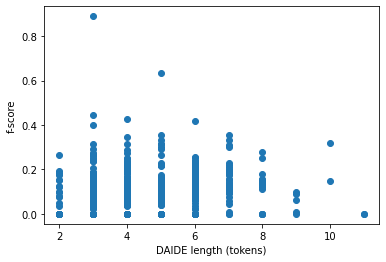

In [5]:
x = np.array(df['DAIDE_length'])
y = np.array(df['F-Score'])

plt.scatter(x, y)
plt.xlabel("DAIDE length (tokens)")
plt.ylabel("f-score")
plt.show()

In [6]:
rslt_df = df[df['F-Score'] < 0.01]
rslt_df.shape
print(f"Percentage of translations with f-score = 0: {round(rslt_df.shape[0]/ count * 100, 2)}%")

Percentage of translations with f-score = 0: 25.44%


In [7]:
np.average(df['F-Score'])

0.1095995575221239